In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import os
import torchvision
import xml.etree.ElementTree as ET
from tqdm import tqdm_notebook as tqdm
import time
import torch.nn.utils.spectral_norm as SN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PATH = '../input/generative-dog-images/all-dogs/'
ANNOTATION_PATH = "../input/generative-dog-images/annotation/Annotation/"
# PATH = '../input/all-dogs/'
# ANNOTATION_PATH = "../input/annotation/Annotation/"
OUTPUT_PATH = '../output_images'

IMG_DIR = "output_images/"

IMAGE_SIZE = 64
BATCH_SIZE = 32
PRINT_EVERY=1000
SHOW_EVERY=1000
PLOT_EVERY=200
EPOCHS=100

lrD = 0.001
lrG = 0.001
beta1 = 0.5
beta2 = 0.999

nz = 128
NFEATS=512
SPECTRAL_NORM=True
NORMALIZATION='adain' # selfmod or adain
RANDOM_NOISE=True
USE_STYLE=True

LOSS='HINGE' #NS or WGAN or HINGE
PIXEL_NORM=True

USE_SOFT_NOISY_LABELS = True
INVERT_LABELS = True
real_label = 0.9
fake_label = 0

N_IMAGES=10000
ComputeLB = True

# Data loading

In [2]:
class DogsDataset(Dataset):
    def __init__(self, root, transform1=None, transform2=None):
        self.root = root
#         super().__init__(root, transform1=transform1, transform2=transform2)
        self.transform1 = transform1
        self.transform2 = transform2
        
        self.samples, self.crops = self._load_subfolders_images(self.root)
        if len(self.samples) == 0:
            raise RuntimeError("Found 0 files in subfolders of: {}".format(self.root))
            
    def _load_subfolders_images(self, root):
        IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

        def is_valid_file(x):
            return torchvision.datasets.folder.has_file_allowed_extension(x, IMG_EXTENSIONS)

        imgs = []
        crops = []

        paths = []
        for root, _, fnames in sorted(os.walk(root)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                paths.append(path)

        pbar = tqdm(paths, desc='Loading cropped images')

        for path in pbar:
            if is_valid_file(path):
                # Load image
                img = torchvision.datasets.folder.default_loader(path)

                # Get bounding boxes
                annotation_basename = os.path.splitext(os.path.basename(path))[0]
                annotation_dirname = next(dirname for dirname in os.listdir(ANNOTATION_PATH) if dirname.startswith(annotation_basename.split('_')[0]))
                annotation_filename = os.path.join(ANNOTATION_PATH, annotation_dirname, annotation_basename)
                tree = ET.parse(annotation_filename)
                root = tree.getroot()
                size = root.find('size')
                width = int(size.find('width').text)
                height = int(size.find('height').text)
                objects = root.findall('object')
                objects = root.findall('object')
                for o in objects:    
                    bndbox = o.find('bndbox') 
                
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)

                    xmin = max(0, xmin - 4)        # 4 : margin
                    xmax = min(width, xmax + 4)
                    ymin = max(0, ymin - 4)
                    ymax = min(height, ymax + 4)

                    w = np.min((xmax - xmin, ymax - ymin))
                    w = min(w, width, height)                     # available w

                    if w > xmax - xmin:
                        xmin = min(max(0, xmin - int((w - (xmax - xmin))/2)), width - w)
                        xmax = xmin + w
                    if w > ymax - ymin:
                        ymin = min(max(0, ymin - int((w - (ymax - ymin))/2)), height - w)
                        ymax = ymin + w

                    img_ = img.crop((xmin, ymin, xmax, ymax)) #img[ymin:ymin+w, xmin:xmin+w, :]      # [h,w,c]

                    if np.mean(img_) != 0:
                        img = img_
                        
#                         if self.transform1 is not None:
#                             img = self.transform1(img)

                        imgs.append(path)
                        crops.append((xmin, ymin, xmax, ymax))
                
                pbar.set_postfix_str("{} cropped images loaded".format(len(imgs)))

        return imgs, crops
    
    def __getitem__(self, index):
        sample = self.samples[index]
        sample = torchvision.datasets.folder.default_loader(sample)
        sample = sample.crop(self.crops[index])
        
        if self.transform2 is not None:
            sample = self.transform2(sample)

        return sample

    def __len__(self):
        return len(self.samples)

In [3]:
# First preprocessing of data
transform1 = None #transforms.Compose([transforms.RandomResizedCrop(64, (1.0, 1.0))])

# Data augmentation and converting to tensors
transform2 = transforms.Compose([transforms.RandomResizedCrop(64, (0.85, 1.0), (1.0, 1.0)),
                                 transforms.ColorJitter(),
                                 transforms.RandomHorizontalFlip(p=0.5), 
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_data = DogsDataset(
    PATH,
    transform1,
    transform2
)

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=BATCH_SIZE, num_workers=4)

# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
class BatchNormModulate2d(nn.Module):
    """
    Similar to batch norm, but with learnable weights and bias
    """
    def __init__(self, num_features, dim_in, eps=2e-5, momentum=0.1, affine=True,
                 track_running_stats=True, use_sn=True):
        super().__init__()
        self.num_features = num_features
        self.dim_in = dim_in
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        self.gamma = nn.Sequential(
            nn.Linear(dim_in, num_features, bias=True),
            nn.LeakyReLU(0.2),
            nn.Linear(num_features, num_features, bias=False)
        )
        self.beta = nn.Sequential(
            nn.Linear(dim_in, num_features, bias=True),
            nn.LeakyReLU(0.2),
            nn.Linear(num_features, num_features, bias=False)
        )

    def forward(self, x, z):
        out = self.bn(x)
        gamma = self.gamma(z)
        beta = self.beta(z)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        return out
    
class PixelNorm(nn.Module):
    def __init__(self, epsilon=1e-8):
        """
            @notice: avoid in-place ops.
            https://discuss.pytorch.org/t/encounter-the-runtimeerror-one-of-the-variables-needed-for-gradient-computation-has-been-modified-by-an-inplace-operation/836/3
        """
        super(PixelNorm, self).__init__()
        self.epsilon = epsilon

    def forward(self, x):
        tmp  = torch.mul(x, x) # or x ** 2
        tmp1 = torch.rsqrt(torch.mean(tmp, dim=1, keepdim=True) + self.epsilon)

        return x * tmp1
    
class GaussianNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))
        
    def forward(self, x, noise=None):
        if noise is None:
            noise = torch.randn(x.shape[0], 1, x.shape[2], x.shape[3], device=x.device, dtype=x.dtype)
        return x + self.weight.view(1, -1, 1, 1) * noise.to(x.device)
    
class AdaIn(nn.Module):
    """
    latent_dim represents dimension of latent vector similar to style vector in StyleGAN
    """
    def __init__(self, in_channel, latent_dim):
        super().__init__()

        self.norm = nn.InstanceNorm2d(in_channel)
        self.style = nn.Linear(latent_dim, in_channel * 2)

    def forward(self, input, style):
        style = self.style(style).unsqueeze(2).unsqueeze(3)
        gamma, beta = style.chunk(2, 1)

        out = self.norm(input)
        out = gamma * out + beta

        return out
        
class Projection(nn.Module):
    def __init__(self, 
                 nz, 
                 in_channel, 
                 out_channel, 
                 shape, 
                 bias=False, 
                 spectral_norm=False, 
                 normalization='selfmod', 
                 random_noise=False,
                 use_style=False,
                 use_pixel_norm=False):
        super().__init__()
        self.shape = shape
        self.linear = nn.Linear(in_channel, out_channel, bias=bias)
        self.conv = nn.Conv2d(shape[0], shape[0], 3, 1, 1, bias=bias)
        if spectral_norm:
            self.linear = SN(self.linear)
            self.conv = SN(self.conv)
            
        self.noise1 = None
        if random_noise:
            self.noise1 = GaussianNoise(shape[0])
            self.noise2 = GaussianNoise(shape[0])
            
        self.pixel_norm = None
        if use_pixel_norm:
            self.pixel_norm = PixelNorm()
            
        self.style1 = None
        self.style2 = None
            
        if normalization == 'adain':
            self.norm1 = AdaIn(shape[0], nz)
            self.norm2 = AdaIn(shape[0], nz)
        else:
            self.norm1 = BatchNormModulate2d(shape[0], nz)
            self.norm2 = BatchNormModulate2d(shape[0], nz)
            
            
    def forward(self, x, nz):
        x = self.linear(x)
        x = x.view([x.shape[0]] + self.shape)
        if self.noise1 is not None:
            x = self.noise1(x)
        x = F.leaky_relu(x, 0.2)
        if self.pixel_norm is not None:
            x = self.pixel_norm(x)
        x = self.norm1(x, nz)
        x = self.conv(x)
        if self.noise2 is not None:
            x = self.noise2(x)
        x = F.leaky_relu(x, 0.2)
        if self.pixel_norm is not None:
            x = self.pixel_norm(x)
        x = self.norm2(x, nz)
        return x
    
class UpConvBlock(nn.Module):
    """
    normalization is 'selfmod', 'adain'
    """
    def __init__(self, 
                 nz, 
                 in_channel, 
                 out_channel, 
                 kernel=4, 
                 stride=2, 
                 padding=1, 
                 bias=False, 
                 spectral_norm=False, 
                 normalization='selfmod', 
                 random_noise=False,
                 use_style=False,
                 use_pixel_norm=False):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(in_channel, out_channel, kernel, stride, padding, bias=bias)
        self.conv2 = nn.Conv2d(out_channel, out_channel, 3, 1, 1, bias=bias)
        if spectral_norm:
            self.conv1 = SN(self.conv1)
            self.conv2 = SN(self.conv2)
            
        self.noise1 = None
        self.noise2 = None
        if random_noise:
            self.noise1 = GaussianNoise(out_channel)
            self.noise2 = GaussianNoise(out_channel)
            
        self.pixel_norm = None
        if use_pixel_norm:
            self.pixel_norm = PixelNorm()
            
        self.style1 = None
        self.style2 = None
        
        if normalization == 'adain':
            self.norm1 = AdaIn(out_channel, nz)
            self.norm2 = AdaIn(out_channel, nz)
        else:
            self.norm1 = BatchNormModulate2d(out_channel, nz)
            self.norm2 = BatchNormModulate2d(out_channel, nz)
            
        
    def forward(self, x, latent):
        x = self.conv1(x)
        if self.noise1 is not None:
            x = self.noise1(x)
        x = F.leaky_relu(x, 0.2)
        if self.pixel_norm is not None:
            x = self.pixel_norm(x)
        x = self.norm1(x, latent)
        x = self.conv2(x)
        if self.noise2 is not None:
            x = self.noise2(x)
        x = F.leaky_relu(x, 0.2)
        if self.pixel_norm is not None:
            x = self.pixel_norm(x)
        x = self.norm2(x, latent)
        return x
        

class Generator(nn.Module):
    def __init__(self, 
                 nz, 
                 nfeats, 
                 nchannels, 
                 bias=False, 
                 spectral_norm=False, 
                 normalization='selfmod', 
                 random_noise=False, 
                 use_style=False,
                 use_pixel_norm=False):
        super(Generator, self).__init__()
        d = nfeats*8
        
        self.mapping = nn.Sequential(
#             nn.Linear(nz, nz, bias=bias),
#             nn.LeakyReLU(0.2),
            SN(nn.Linear(nz, nz, bias=bias)),
            nn.LeakyReLU(0.2)
        )
        
        self.linear = Projection(nz, nz, 8*8*nfeats, [nfeats, 8, 8], bias, spectral_norm, normalization, random_noise, use_style, use_pixel_norm) 
        # state size. (nfeats*16) x 4 x 4
        
        self.conv2 = UpConvBlock(nz, nfeats, nfeats//2, 4, 2, 1, bias, spectral_norm, normalization, random_noise, use_style, use_pixel_norm) 
        # state size. (nfeats*8) x 8 x 8
        
        self.conv3 = UpConvBlock(nz, nfeats//2, nfeats//4, 4, 2, 1, bias, spectral_norm, normalization, random_noise, use_style, use_pixel_norm) 
        # state size. (nfeats*4) x 16 x 16
        
        self.conv4 = UpConvBlock(nz, nfeats//4, nfeats//8, 4, 2, 1, bias, spectral_norm, normalization, random_noise, use_style, use_pixel_norm)
        # state size. (nfeats*2) x 32 x 32
        
#         self.conv5 = UpConvBlock(nz, nfeats//8, nfeats//16, 4, 2, 1, bias, spectral_norm, normalization, random_noise, use_style, use_pixel_norm)
        
        self.conv6 = nn.Conv2d(nfeats//8, nchannels, 1, 1, 0, bias=bias)
        if spectral_norm:
            self.conv6 = SN(self.conv6)
        # state size. (nchannels) x 64 x 64

    def forward(self, x):
        latent = self.mapping(x)
        out = self.linear(x, latent)
        out = self.conv2(out, latent)
        out = self.conv3(out, latent)
        out = self.conv4(out, latent)
#         out = self.conv5(out, latent)
        out = torch.tanh(self.conv6(out))
        
        return out



class Discriminator(nn.Module):
    def __init__(self, nchannels, nfeats):
        super(Discriminator, self).__init__()
        d = nfeats
        # input is (nchannels) x 64 x 64
        self.from_rgb = nn.Sequential(
            SN(nn.Conv2d(nchannels, d//8, 1, 1, 0, bias=False)),
            nn.BatchNorm2d(d//8),
            nn.LeakyReLU(0.2)
        )
#         self.conv1 = nn.Sequential(
#             SN(nn.Conv2d(d//16, d//16, 3, 1, 1, bias=True)),
#             nn.BatchNorm2d(d//16),
#             nn.LeakyReLU(0.2),
#             SN(nn.Conv2d(d//16, d//8, 4, 2, 1, bias=True)),
#             nn.BatchNorm2d(d//8),
#             nn.LeakyReLU(0.2)
#         )
        # (nfeats) x 64 x 64
        
        self.conv2 = nn.Sequential(
            SN(nn.Conv2d(d//8, d//8, 3, 1, 1, bias=False)),
            nn.BatchNorm2d(d//8),
            nn.LeakyReLU(0.2),
            SN(nn.Conv2d(d//8, d//4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(d//4),
            nn.LeakyReLU(0.2)
        )
        # (2*nfeats) x 32 x 32
        
        self.conv3 = nn.Sequential(
            SN(nn.Conv2d(d//4, d//4, 3, 1, 1, bias=False)),
            nn.BatchNorm2d(d//4),
            nn.LeakyReLU(0.2),
            SN(nn.Conv2d(d//4, d//2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(d//2),
            nn.LeakyReLU(0.2)
        )
        # (4*nfeats) x 16 x 16
        
        self.conv4 = nn.Sequential(
            SN(nn.Conv2d(d//2, d//2, 3, 1, 1, bias=False)),
            nn.BatchNorm2d(d//2),
            nn.LeakyReLU(0.2),
            SN(nn.Conv2d(d//2, d, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(d),
            nn.LeakyReLU(0.2)
        )
        # (8*nfeats) x 8 x 8
        
        self.conv5 = nn.Sequential(
            SN(nn.Conv2d(d, d, 3, 1, 1, bias=False)),
            nn.BatchNorm2d(d),
            nn.LeakyReLU(0.2)
        )
        
        self.linear = SN(nn.Linear(8*8*d, 1, bias=False))
#         self.linear = nn.Sequential(
#             SN(nn.Conv2d(nfeats, 1, 1, 1, 0))
#         )
        
        
    def forward(self, x):
        x = self.from_rgb(x)
#         x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        return x

# Define training loop

In [5]:
from numpy.random import choice
import random

def gradient_penalty(x, y, f):
    # interpolation
    shape = [x.size(0)] + [1] * (x.dim() - 1)
    alpha = torch.rand(shape).to(x.device)
    z = x + alpha * (y - x)

    # gradient penalty
    z = Variable(z, requires_grad=True).to(x.device)
    o = f(z)
    g = grad(o, z, grad_outputs=torch.ones(o.size()).to(z.device), create_graph=True)[0].view(z.size(0), -1)
    gp = ((g.norm(p=2, dim=1) - 1)**2).mean()
    return gp
    
def R1Penalty(real_img, f):
    # gradient penalty
    reals = Variable(real_img, requires_grad=True).to(real_img.device)
    real_logit = f(reals)
    apply_loss_scaling = lambda x: x * torch.exp(x * torch.Tensor([np.float32(np.log(2.0))]).to(real_img.device))
    undo_loss_scaling = lambda x: x * torch.exp(-x * torch.Tensor([np.float32(np.log(2.0))]).to(real_img.device))

    real_logit = apply_loss_scaling(torch.sum(real_logit))
    real_grads = grad(real_logit, reals, grad_outputs=torch.ones(real_logit.size()).to(reals.device), create_graph=True)[0].view(reals.size(0), -1)
    real_grads = undo_loss_scaling(real_grads)
    r1_penalty = torch.sum(torch.mul(real_grads, real_grads))
    return r1_penalty

def G_wgan(G, D, nz, batch_size):
    noise = torch.randn(batch_size, nz, device=device)
    fake_images = G(noise)
    fake_logit = D(fake_images)
    G_loss = -fake_logit.mean()
    return G_loss

def D_wgan_gp(G, D, real_images, nz, lammy=10.0, eps=0.001):
    batch_size = real_images.shape[0]
    real_logit = D(real_images)
    noise = torch.randn(batch_size, nz, device=device)
    fake_images = G(noise)
    fake_logit = D(fake_images.detach())
    D_loss = fake_logit.mean() - real_logit.mean()
    D_loss += gradient_penalty(real_images.data, fake_images.data, D) * lammy
#     D_loss += real_logit.mean()**2 * eps
    return D_loss
    
def D_NS(G, D, real_images, nz, real_labels, fake_labels):
    batch_size = real_images.shape[0]
    real_logit = D(real_images)
    D_loss_real = F.binary_cross_entropy_with_logits(real_logit, real_labels)
    noise = torch.randn(batch_size, nz, device=device)
    fake_images = G(noise)
    fake_logit = D(fake_images.detach())
    D_loss_fake = F.binary_cross_entropy_with_logits(fake_logit, fake_labels)
    D_loss = D_loss_real + D_loss_fake
    return D_loss, D_loss_real.item(), D_loss_fake.item()
    
def G_NS(G, D, nz, batch_size, real_labels):
    noise = torch.randn(batch_size, nz, device=device)
    fake_images = G(noise)
    fake_logit = D(fake_images)
    G_loss = F.binary_cross_entropy_with_logits(fake_logit, real_labels)
    return G_loss

def D_Hinge(G, D, real_images, nz):
    batch_size = real_images.shape[0]
    real_logit = D(real_images)
    D_loss_real = torch.mean(F.relu(1.0 - real_logit)) 
    noise = torch.randn(batch_size, nz, device=device)
    fake_images = G(noise)
    fake_logit = D(fake_images.detach())
    D_loss_fake = torch.mean(F.relu(1.0 + fake_logit)) 
    D_loss = D_loss_real + D_loss_fake
    return D_loss, D_loss_real, D_loss_fake

def G_Hinge(G, D, nz, batch_size):
    noise = torch.randn(batch_size, nz, device=device)
    fake_images = G(noise)
    fake_logit = D(fake_images)
    G_loss = -torch.mean(fake_logit)
    return G_loss

class Trainer:
    def __init__(self, nz, G, D, r1_gamma=0.0, track_grads=False):
        self.nz = nz
        self.track_grads=track_grads
        self.G = G
        self.D = D
        self.fixed_noise = torch.randn(64, self.nz)
        self.r1_gamma = r1_gamma
        
        self.d_losses = []
        self.g_losses = []
        self.d_losses_real = []
        self.d_losses_fake = []
        self.img_list = []
        self.g_grads = []
        self.d_grads = []
        
    def check_grads(self, model):
        grads = []
        for n, p in model.named_parameters():
            if not p.grad is None and p.requires_grad and "bias" not in n:
                grads.append(float(p.grad.abs().mean()))
        return grads
        
    def train(self, epochs, loader, criterion, optim_G, optim_D, scheduler_D, scheduler_G, print_every, show_every, plot_every, loss='NS'):
        step = 0
        
        for epoch in tqdm(range(epochs)):
            for ii, real_images in enumerate(loader):
                batch_size = real_images.size(0)
                if USE_SOFT_NOISY_LABELS:
                    real_labels = torch.empty((batch_size, 1), device=device).uniform_(0.80, 0.95)
                    fake_labels = torch.empty((batch_size, 1), device=device).uniform_(0.05, 0.20)
                else:
                    real_labels = torch.full((batch_size, 1), 0.95, device=device)
                    fake_labels = torch.full((batch_size, 1), 0.05, device=device)
                
                if INVERT_LABELS and random.random() < 0.01:
                    real_labels, fake_labels = fake_labels, real_labels
                # Train Discriminator
                self.D.zero_grad()
                real_images = real_images.to(device)
                
                if loss == 'WGAN':
                    D_loss = D_wgan_gp(self.G, self.D, real_images, self.nz)
                elif loss == 'HINGE':
                    D_loss, D_loss_real, D_loss_fake = D_Hinge(self.G, self.D, real_images, self.nz)
                else:
                    D_loss, D_loss_real, D_loss_fake = D_NS(self.G, self.D, real_images, self.nz, real_labels, fake_labels)
                
                D_loss.backward()
                optim_D.step()
                
                # Train Generator
                self.G.zero_grad()
                
                if loss == 'WGAN':
                    G_loss = G_wgan(self.G, self.D, self.nz, batch_size)
                elif loss == 'HINGE':
                    G_loss = G_Hinge(self.G, self.D, self.nz, batch_size)
                else:
                    G_loss = G_NS(self.G, self.D, self.nz, batch_size, real_labels)
                G_loss.backward()
                optim_G.step()
                
                if step % print_every == 0:
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f' 
                      % (epoch, epochs, ii, len(loader),
                         D_loss.item(), G_loss.item(), D_loss_real, D_loss_fake))
                
                if step % plot_every == 0:
                    self.d_losses.append(D_loss.item())
                    self.g_losses.append(G_loss.item())
                    self.d_losses_real.append(D_loss_real)
                    self.d_losses_fake.append(D_loss_fake)
                    if self.track_grads:
                        self.g_grads.append(self.check_grads(self.G))
                        self.d_grads.append(self.check_grads(self.D))
                
                if (step % show_every == 0) or ((epoch == epochs-1) and (ii == len(loader)-1)):
                    with torch.no_grad():
                        fake = self.G(self.fixed_noise.to(device)).detach().cpu()
                    self.img_list.append(make_grid(fake, padding=2, normalize=True))
                
                step += 1
#             scheduler_D.step()
#             scheduler_G.step()

In [6]:
netG = Generator(nz, NFEATS, 3, False, SPECTRAL_NORM, NORMALIZATION, RANDOM_NOISE, USE_STYLE, PIXEL_NORM).to(device)
print(netG)

Generator(
  (mapping): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=False)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (linear): Projection(
    (linear): Linear(in_features=128, out_features=32768, bias=False)
    (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (noise1): GaussianNoise()
    (noise2): GaussianNoise()
    (pixel_norm): PixelNorm()
    (norm1): AdaIn(
      (norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (style): Linear(in_features=128, out_features=1024, bias=True)
    )
    (norm2): AdaIn(
      (norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (style): Linear(in_features=128, out_features=1024, bias=True)
    )
  )
  (conv2): UpConvBlock(
    (conv1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1

In [7]:
netD = Discriminator(3, NFEATS).to(device)
print(netD)

Discriminator(
  (from_rgb): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 

In [8]:
def weights_init(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        torch.nn.init.kaiming_uniform(m.weight)
        if m.bias is not None:
            m.bias.data.zero_()
#             m.bias.data.fill_(0.01)

In [9]:

netG.apply(weights_init)
netD.apply(weights_init)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, beta2))
scheduler_D = optim.lr_scheduler.ExponentialLR(optimizerD, gamma=0.99)
scheduler_G = optim.lr_scheduler.ExponentialLR(optimizerG, gamma=0.99)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
trainer = Trainer(nz, netG, netD, track_grads=True)
trainer.train(EPOCHS, train_loader, criterion, optimizerG, optimizerD, scheduler_D, scheduler_G, PRINT_EVERY, SHOW_EVERY, PLOT_EVERY, loss=LOSS)
               
# torch.save(netG.state_dict(), 'generator.pth')
# torch.save(netD.state_dict(), 'discriminator.pth')

[0/100][0/671]	Loss_D: 2.0188	Loss_G: 3.9106	D(x): 0.7244	D(G(z)): 1.2944
[1/100][329/671]	Loss_D: 0.0028	Loss_G: 1.5370	D(x): 0.0028	D(G(z)): 0.0000
[2/100][658/671]	Loss_D: 0.0000	Loss_G: 1.5921	D(x): 0.0000	D(G(z)): 0.0000
[4/100][316/671]	Loss_D: 0.0000	Loss_G: 1.8502	D(x): 0.0000	D(G(z)): 0.0000
[5/100][645/671]	Loss_D: 0.0000	Loss_G: 1.9679	D(x): 0.0000	D(G(z)): 0.0000
[7/100][303/671]	Loss_D: 0.0000	Loss_G: 1.7833	D(x): 0.0000	D(G(z)): 0.0000
[8/100][632/671]	Loss_D: 0.0000	Loss_G: 1.7590	D(x): 0.0000	D(G(z)): 0.0000
[10/100][290/671]	Loss_D: 0.0000	Loss_G: 1.6929	D(x): 0.0000	D(G(z)): 0.0000
[11/100][619/671]	Loss_D: 0.0996	Loss_G: 1.0785	D(x): 0.0000	D(G(z)): 0.0996
[13/100][277/671]	Loss_D: 1.4793	Loss_G: -0.0314	D(x): 0.1732	D(G(z)): 1.3062
[14/100][606/671]	Loss_D: 1.7467	Loss_G: -0.2929	D(x): 1.3692	D(G(z)): 0.3775
[16/100][264/671]	Loss_D: 1.9234	Loss_G: 0.3353	D(x): 0.7458	D(G(z)): 1.1776
[17/100][593/671]	Loss_D: 2.1881	Loss_G: -0.0878	D(x): 0.7578	D(G(z)): 1.4302
[19/1

# Look at results

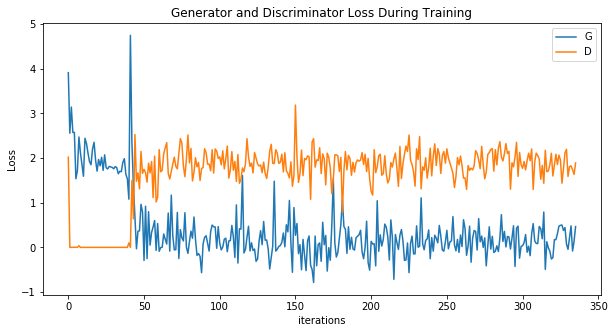

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(trainer.g_losses,label="G")
plt.plot(trainer.d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

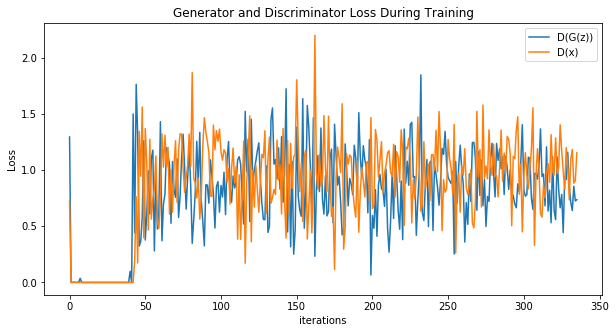

In [12]:
# Show D(x) and D(G(z))
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(trainer.d_losses_fake,label="D(G(z))")
plt.plot(trainer.d_losses_real,label="D(x)")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

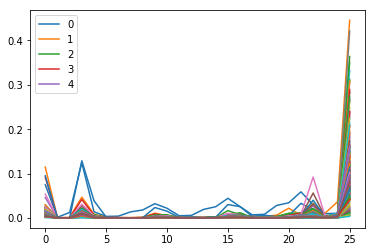

In [13]:
# Check the gradients for G
for i in trainer.g_grads: plt.plot(i)
plt.legend(range(5))

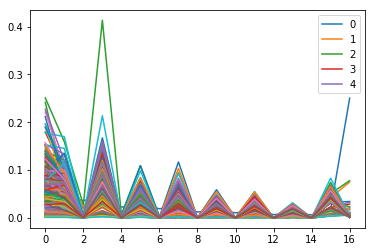

In [14]:
# Check the gradients for D
for i in trainer.d_grads: plt.plot(i)
plt.legend(range(5))

# Visualize progression

In [15]:
# import matplotlib.animation as animation
# from IPython.display import HTML

# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=False)] for i in trainer.img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
# HTML(ani.to_jshtml())


# Real versus fake images

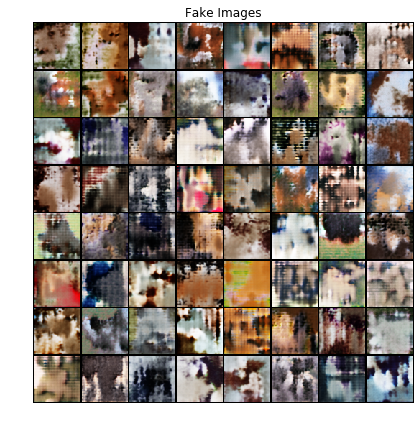

In [16]:
# Grab a batch of real images from the dataloader

# # Plot the real images
plt.figure(figsize=(15,15))

# Plot the fake images from the last epoch
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(trainer.img_list[-1],(1,2,0)))
plt.show()

In [17]:
if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)
with torch.no_grad():
    for i_batch in range(0, N_IMAGES, 25):
        gen_z = torch.randn(25, nz, device=device)
        gen_images = netG(gen_z)
        images = gen_images.to("cpu").clone().detach()
        images = images.numpy().transpose(0, 2, 3, 1)
        for i_image in range(gen_images.size(0)):
            save_image(gen_images[i_image, :, :, :]*0.5 + 0.5, os.path.join(OUTPUT_PATH, f'image_{i_batch+i_image:05d}.png'))

import shutil
shutil.make_archive('images', 'zip', OUTPUT_PATH)

'/kaggle/working/images.zip'

# Compute leadboard

In [18]:
from __future__ import absolute_import, division, print_function
import numpy as np
import os
import gzip, pickle
import tensorflow as tf
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm
from PIL import Image

class KernelEvalException(Exception):
    pass

model_params = {
    'Inception': {
        'name': 'Inception', 
        'imsize': 64,
        'output_layer': 'Pretrained_Net/pool_3:0', 
        'input_layer': 'Pretrained_Net/ExpandDims:0',
        'output_shape': 2048,
        'cosine_distance_eps': 0.1
        }
}

def create_model_graph(pth):
    """Creates a graph from saved GraphDef file."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile( pth, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString( f.read())
        _ = tf.import_graph_def( graph_def, name='Pretrained_Net')

def _get_model_layer(sess, model_name):
    # layername = 'Pretrained_Net/final_layer/Mean:0'
    layername = model_params[model_name]['output_layer']
    layer = sess.graph.get_tensor_by_name(layername)
    ops = layer.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            if shape._dims != []:
              shape = [s.value for s in shape]
              new_shape = []
              for j, s in enumerate(shape):
                if s == 1 and j == 0:
                  new_shape.append(None)
                else:
                  new_shape.append(s)
              o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
    return layer

def get_activations(images, sess, model_name, batch_size=50, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 256.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the disposable hardware.
    -- verbose    : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- A numpy array of dimension (num images, 2048) that contains the
       activations of the given tensor when feeding inception with the query tensor.
    """
    inception_layer = _get_model_layer(sess, model_name)
    n_images = images.shape[0]
    if batch_size > n_images:
        print("warning: batch size is bigger than the data size. setting batch size to data size")
        batch_size = n_images
    n_batches = n_images//batch_size + 1
    pred_arr = np.empty((n_images,model_params[model_name]['output_shape']))
    for i in tqdm(range(n_batches)):
        if verbose:
            print("\rPropagating batch %d/%d" % (i+1, n_batches), end="", flush=True)
        start = i*batch_size
        if start+batch_size < n_images:
            end = start+batch_size
        else:
            end = n_images
                    
        batch = images[start:end]
        pred = sess.run(inception_layer, {model_params[model_name]['input_layer']: batch})
        pred_arr[start:end] = pred.reshape(-1,model_params[model_name]['output_shape'])
    if verbose:
        print(" done")
    return pred_arr


# def calculate_memorization_distance(features1, features2):
#     neigh = NearestNeighbors(n_neighbors=1, algorithm='kd_tree', metric='euclidean')
#     neigh.fit(features2) 
#     d, _ = neigh.kneighbors(features1, return_distance=True)
#     print('d.shape=',d.shape)
#     return np.mean(d)

def normalize_rows(x: np.ndarray):
    """
    function that normalizes each row of the matrix x to have unit length.

    Args:
     ``x``: A numpy matrix of shape (n, m)

    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return np.nan_to_num(x/np.linalg.norm(x, ord=2, axis=1, keepdims=True))


def cosine_distance(features1, features2):
    # print('rows of zeros in features1 = ',sum(np.sum(features1, axis=1) == 0))
    # print('rows of zeros in features2 = ',sum(np.sum(features2, axis=1) == 0))
    features1_nozero = features1[np.sum(features1, axis=1) != 0]
    features2_nozero = features2[np.sum(features2, axis=1) != 0]
    norm_f1 = normalize_rows(features1_nozero)
    norm_f2 = normalize_rows(features2_nozero)

    d = 1.0-np.abs(np.matmul(norm_f1, norm_f2.T))
    print('d.shape=',d.shape)
    print('np.min(d, axis=1).shape=',np.min(d, axis=1).shape)
    mean_min_d = np.mean(np.min(d, axis=1))
    print('distance=',mean_min_d)
    return mean_min_d


def distance_thresholding(d, eps):
    if d < eps:
        return d
    else:
        return 1

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        # covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    # covmean = tf.linalg.sqrtm(tf.linalg.matmul(sigma1,sigma2))

    print('covmean.shape=',covmean.shape)
    # tr_covmean = tf.linalg.trace(covmean)

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    # return diff.dot(diff) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean
#-------------------------------------------------------------------------------


def calculate_activation_statistics(images, sess, model_name, batch_size=50, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 255.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the available hardware.
    -- verbose     : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the incption model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the incption model.
    """
    act = get_activations(images, sess, model_name, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma, act
    
def _handle_path_memorization(path, sess, model_name, is_checksize, is_check_png):
    path = pathlib.Path(path)
    files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
    imsize = model_params[model_name]['imsize']

    # In production we don't resize input images. This is just for demo purpose. 
    x = np.array([np.array(img_read_checks(fn, imsize, is_checksize, imsize, is_check_png)) for fn in files])
    m, s, features = calculate_activation_statistics(x, sess, model_name)
    del x #clean up memory
    return m, s, features

# check for image size
def img_read_checks(filename, resize_to, is_checksize=False, check_imsize = 64, is_check_png = False):
    im = Image.open(str(filename))
    if is_checksize and im.size != (check_imsize,check_imsize):
        raise KernelEvalException('The images are not of size '+str(check_imsize))
    
    if is_check_png and im.format != 'PNG':
        raise KernelEvalException('Only PNG images should be submitted.')

    if resize_to is None:
        return im
    else:
        return im.resize((resize_to,resize_to),Image.ANTIALIAS)

def calculate_kid_given_paths(paths, model_name, model_path, feature_path=None, mm=[], ss=[], ff=[]):
    ''' Calculates the KID of two paths. '''
    tf.reset_default_graph()
    create_model_graph(str(model_path))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        m1, s1, features1 = _handle_path_memorization(paths[0], sess, model_name, is_checksize = True, is_check_png = True)
        if len(mm) != 0:
            m2 = mm
            s2 = ss
            features2 = ff
        elif feature_path is None:
            m2, s2, features2 = _handle_path_memorization(paths[1], sess, model_name, is_checksize = False, is_check_png = False)
        else:
            with np.load(feature_path) as f:
                m2, s2, features2 = f['m'], f['s'], f['features']

        print('m1,m2 shape=',(m1.shape,m2.shape),'s1,s2=',(s1.shape,s2.shape))
        print('starting calculating FID')
        fid_value = calculate_frechet_distance(m1, s1, m2, s2)
        print('done with FID, starting distance calculation')
        distance = cosine_distance(features1, features2)        
        return fid_value, distance, m2, s2, features2

In [19]:
import zipfile
if ComputeLB:
  
    # UNCOMPRESS OUR IMGAES
    with zipfile.ZipFile("../working/images.zip","r") as z:
        z.extractall("../tmp/images2/")

    # COMPUTE LB SCORE
    m2 = []; s2 =[]; f2 = []
    user_images_unzipped_path = '../tmp/images2/'
    images_path = [user_images_unzipped_path,'../input/generative-dog-images/all-dogs/all-dogs/']
    public_path = '../input/dog-face-generation-competition-kid-metric-input/classify_image_graph_def.pb'

    fid_epsilon = 10e-15

    fid_value_public, distance_public, m2, s2, f2 = calculate_kid_given_paths(images_path, 'Inception', public_path, mm=m2, ss=s2, ff=f2)
    distance_public = distance_thresholding(distance_public, model_params['Inception']['cosine_distance_eps'])
    print("FID_public: ", fid_value_public, "distance_public: ", distance_public, "multiplied_public: ",
            fid_value_public /(distance_public + fid_epsilon))
    
    # REMOVE FILES TO PREVENT KERNEL ERROR OF TOO MANY FILES
    ! rm -r ../tmp

100%|██████████| 412/412 [01:09<00:00,  4.21it/s]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation
d.shape= (10000, 20579)
np.min(d, axis=1).shape= (10000,)
distance= 0.32530723449784726
FID_public:  186.81091003372148 distance_public:  1 multiplied_public:  186.8109100337196
